In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics

import numpy as np
import pandas as pd
import plotly.express as px
from PIL import Image
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%config InlineBackend.figure_formats = ['svg']

import os
from torchvision.io import read_image
import torchvision.transforms.functional as F
from torch.utils.data import Dataset,random_split
from torchvision.utils import make_grid
from torchvision import datasets
import torchvision.transforms as tr
from pathlib import Path

torch.manual_seed(42)
import cv2 as cv
from torch.utils.tensorboard import SummaryWriter
from PIL import Image

2023-04-20 18:33:43.712613: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_dir = Path('brain_cancer')
CANTIDAD_CLASES = 15
ANCHO_IMAGENES = 224
ALTO_IMAGENES = 224

In [3]:
class CustomBrainDataset(Dataset):
    
    def __init__(self, base_dir, transforms = None):
        """
        Arguments:
            base_dir: str
                Directory where the dataset is stored
            transforms: iterable
                Collection of transforms to apply when loading an image
        """
        
        self.base_dir = Path(base_dir)
        self.transforms = transforms
        
        self.data_dicts = []

        for img in self.base_dir.glob("*oma*/*.jp*g"):
            img_dict = {}
            img_dict["img_path"] = img
            img_dict["label"],img_dict["img_type"] = img.parent.name.split(" ")

            self.data_dicts.append(img_dict)
            
        for img in self.base_dir.glob("*NORMAL*/*.jp*g"):
            img_dict = {}
            img_dict["img_path"] = img
            img_dict["label"],img_dict["img_type"] = "Normal", img.parent.name.split(" ")[1]
            self.data_dicts.append(img_dict)
        
        self.data = pd.DataFrame(self.data_dicts)
        self.labels = self.data["label"]
        
        self.encoder = LabelEncoder()
        self.y = self.encoder.fit_transform(self.labels)
        self.num_classes = len(self.encoder.classes_)
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open(self.data.loc[idx,"img_path"]).convert("RGB")
        label = self.y[idx]
        
        if self.transforms is not None:
            return self.transforms(image), label
        else:
            return image, label
        
    def display(self,idxs):
        """
        Display a few images from the dataset.
        Arguments:
            idxs: iterable
                Collection of indices of the images that will be displayed
        Returns:
            fig, axs:
                Matplotlib Figure and List(Axes) where the images are rendered
                
        
        Example: 
            BrainDataset().display([1,2])
        """
        
        img_list = [F.to_pil_image(self[idx][0]) for idx in idxs]
            
        labels = [self.labels[idx] for idx in idxs]
        
        fig,axs = plt.subplots(ncols=len(idxs),nrows=1,squeeze=False,figsize=(10,len(idxs)*16))
        
        for i,ax in enumerate(axs.flat):
            ax.imshow(img_list[i],cmap='gray')
            ax.set_title(labels[i],size=8)
            ax.grid()
            ax.axis('off')
            
        return fig,axs
    
    def _ipython_display_(self):
        display(self.data)

In [4]:
brain_data = CustomBrainDataset(base_dir, transforms=tr.ToTensor())

Vemos un poco los datos

In [5]:
len(brain_data)

4465

In [6]:
brain_data.data

,img_path,label,img_type
0,brain_cancer/Granuloma T2/21590bee4e4d08b3d11c...,Granuloma,T2
1,brain_cancer/Granuloma T2/8f3d2d6a5c6c52d7a058...,Granuloma,T2
2,brain_cancer/Granuloma T2/537bc3a5642a5e65ef04...,Granuloma,T2
3,brain_cancer/Granuloma T2/374ab0afb71b60c1aaf9...,Granuloma,T2
4,brain_cancer/Granuloma T2/a390b23ec3de409ae1ac...,Granuloma,T2
...,...,...,...
4460,brain_cancer/_NORMAL T2/92ec9e3ff44e877fdb6858...,Normal,T2
4461,brain_cancer/_NORMAL T2/fdffa3aa06bcd0d7445d1d...,Normal,T2
4462,brain_cancer/_NORMAL T2/3e7ea84b812afc10528144...,Normal,T2
4463,brain_cancer/_NORMAL T2/ea782e1e91160ed77c7838...,Normal,T2


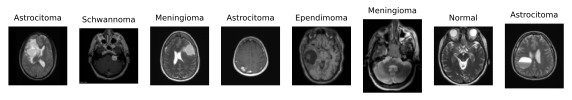

In [7]:
idxs = np.random.choice(len(brain_data),size=8)
brain_data.display(idxs);

In [8]:
brain_data.data.describe()

,img_path,label,img_type
count,4465,4465,4465
unique,4465,15,3
top,brain_cancer/Granuloma T2/21590bee4e4d08b3d11c...,Meningioma,T1C+
freq,1,874,1686


In [9]:
px.histogram(brain_data.data,x="label")

Se da que en casi todas las imagenes hay bordes negros que son datos que no aportan información. Podemos recortar estos bordes sin dañar la precisión del modelo, y minimizando el cómputo innecesario.

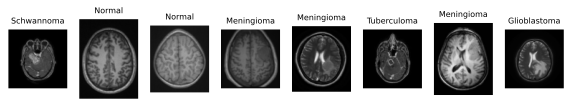

In [10]:
idxs = np.random.choice(len(brain_data),size=8)
brain_data.display(idxs);

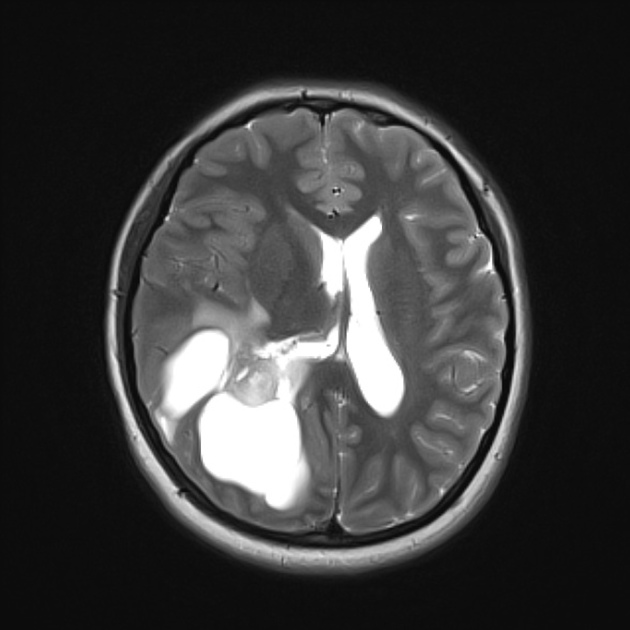

In [11]:
img = F.to_pil_image(brain_data[50][0])
img

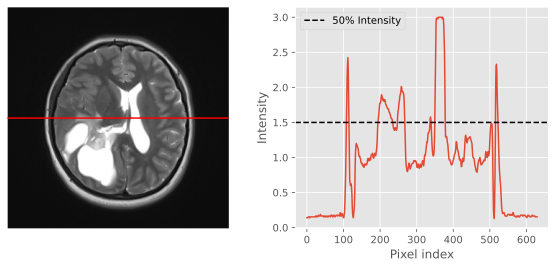

In [12]:
imgT = tr.ToTensor()(img)[:,:,]
C,H,W = imgT.shape

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].imshow(img)
ax[0].axhline(H//2,color="red")
ax[0].grid()
ax[0].axis("off");
       
ax[1].plot(torch.sum(imgT[:,H//2,:],axis=0))
ax[1].set_xlabel("Pixel index")
ax[1].set_ylabel("Intensity")
ax[1].axhline(0.5*torch.max(torch.sum(imgT,axis=0)),color="Black",label="50% Intensity",linestyle="--")
ax[1].legend();

In [14]:
# Heredamos de nn.Module para definir una transformación custom
class CropThreshold(torch.nn.Module):

    def __init__(self,threshold=0.1,ignore_frame_pixels=5):
        super().__init__()
        self.threshold = threshold
        self.ignore_frame_pixels = ignore_frame_pixels if ignore_frame_pixels > 0 else None

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be cropped.
        Returns:
            Tensor: Cropped image.
        """

        C,H,W = img.shape
        
        skipH = self.ignore_frame_pixels
        skipT = -self.ignore_frame_pixels if self.ignore_frame_pixels is not None else None
        
        ymax = torch.max(torch.sum(img[:,H//2,skipH:skipT],axis=0))
        xmax = torch.max(torch.sum(img[:,skipH:skipT,W//2],axis=0))
           
        bottom, top = torch.nonzero(torch.sum(img[:,H//2,skipH:skipT],axis=0) > self.threshold*ymax)[[0,-1]]
        left, right = torch.nonzero(torch.sum(img[:,skipH:skipT,W//2],axis=0) > self.threshold*xmax)[[0,-1]]

        return F.center_crop(img,output_size=[(right-left).item(),(top-bottom).item()])
    
    def __repr__(self):
        return f"CropToContent(threshold={self.threshold})"

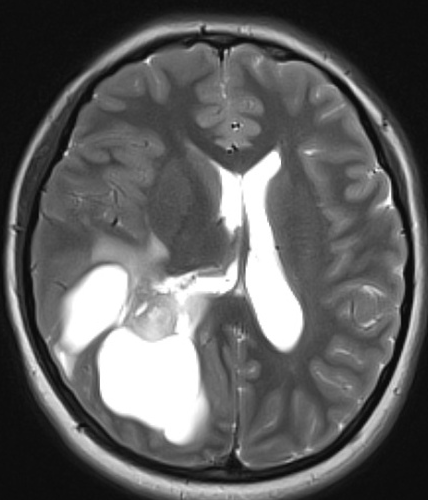

In [15]:
F.to_pil_image(CropThreshold(threshold=0.1,ignore_frame_pixels=1)(F.to_tensor(img)))

In [16]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        CropThreshold(),
                        torchvision.transforms.RandomRotation(degrees=10),
                        torchvision.transforms.ColorJitter(contrast=(0.75, 1.25)),
                        torchvision.transforms.GaussianBlur(kernel_size=(13, 15), sigma=(3, 5)),
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES))
                      ])


data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        CropThreshold(threshold=0.1,ignore_frame_pixels=5),
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                      ])

In [18]:
brain_data = CustomBrainDataset(base_dir,transforms=aug_data_transforms)

val_set_size = int(len(brain_data) * 0.2)
train_set, valid_set = random_split(brain_data,[len(brain_data)-val_set_size,val_set_size])
import torch.utils.data as data_utils

indices = torch.arange(100)
subset_train = data_utils.Subset(train_set, indices)
subset_valid = data_utils.Subset(valid_set, indices)
train_subset_loader = torch.utils.data.DataLoader(subset_train, batch_size=32, shuffle=True)
valid_subset_loader = torch.utils.data.DataLoader(subset_valid, batch_size=32, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

Entrenamos un modelo vgg. Vemos una comparativa de diversos modelos: https://wandb.ai/huyvnphan/cifar10?workspace=user-

In [19]:
from torchvision.models.vgg import VGG19_BN_Weights
weights = VGG19_BN_Weights.IMAGENET1K_V1
transforms = weights.transforms()

vgg19_model = torchvision.models.vgg19_bn(weights=weights)

#vgg19_model.to("cuda")

torchsummary.summary(vgg19_model, input_size=(3, 224, 224))
vgg19_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

El primer paso para realizar Transfer Learning seria congelar las capas del modelo base seleccionado. Para hacer eso en PyTorch debemos poner en False la variable requires_grad de cada uno de los parametros que integran el modelo.



In [20]:
for param in vgg19_model.parameters():
    param.requires_grad = False

Luego, en base a la arquitectura particular del modelo base, modificamos las capas que nosotros queremos, asignando una nueva capa, la cual, por defecto, tendra requires_grad = True. Esta nueva capa debe tener tantas neuronas como clases tiene el dataset objetivo sobre el que vamos a realizar el entrenamiento.


In [21]:
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

In [22]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

Uso un modelo custom

In [23]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.pool5 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv6 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding='same')
        self.pool6 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=4608, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = self.pool5(torch.relu(self.conv5(x)))
        x = self.pool6(torch.relu(self.conv6(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          18,496
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]          73,856
         MaxPool2d-8          [-1, 128, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         295,168
        MaxPool2d-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 512, 7, 7]       1,180,160
        MaxPool2d-12            [-1, 512, 3, 3]               0
           Linear-13                  [-1, 512]       2,359,808
           Linear-14                   

In [24]:
import torchvision.transforms.functional as functional

class AugmentableBrainDataset(Dataset):
    
    def __init__(self, base_dir, transforms = None):
        """
        Arguments:
            base_dir: str
                Directory where the dataset is stored
            transforms: iterable
                Collection of transforms to apply when loading an image
        """
        
        self.base_dir = Path(base_dir)
        self.transforms = transforms
        
        self.data_dicts = []

        for img in self.base_dir.glob("*oma*/*.jp*g"):
            # Get all images of sick patients, every tumor name contains "oma" 
            img_dict = {}
            img_dict["img_path"] = img
            img_dict["label"],img_dict["img_type"] = img.parent.name.split(" ")

            self.data_dicts.append(img_dict)

            if img_dict["label"] != 'Meningioma':
                # Make augmentations over images
                image = Image.open(img).convert("RGB") # read image into a PIL Image
                t = torchvision.transforms.ToTensor()
                image = t(image)

                t = torchvision.transforms.RandomRotation(degrees=10)
                new_image = t(image)
                img_dict = {}
                img_dict["img_path"] = img
                img_dict["img"] = functional.to_pil_image(new_image)
                img_dict["label"],img_dict["img_type"] = img.parent.name.split(" ")[0], 'augmented'

                self.data_dicts.append(img_dict)
                if img_dict["label"] != 'Astrocitoma' and img_dict["label"] != 'Neurocitoma'  and img_dict["label"] != 'Schwannoma':
                    t = torchvision.transforms.ColorJitter(contrast=(0.75, 1.25))
                    new_image = t(image)
                    img_dict = {}
                    img_dict["img_path"] = img
                    img_dict["img"] = functional.to_pil_image(new_image)
                    img_dict["label"],img_dict["img_type"] = img.parent.name.split(" ")[0], 'augmented'

                    self.data_dicts.append(img_dict)

                    t = torchvision.transforms.GaussianBlur(kernel_size=(13, 15), sigma=(3, 5))
                    new_image = t(image)
                    img_dict = {}
                    img_dict["img_path"] = img
                    img_dict["img"] = functional.to_pil_image(new_image)
                    img_dict["label"],img_dict["img_type"] = img.parent.name.split(" ")[0], 'augmented'

                    self.data_dicts.append(img_dict)
            
        for img in self.base_dir.glob("*NORMAL*/*.jp*g"):
            # Get all images of normal patients    
            img_dict = {}
            img_dict["img_path"] = img
            img_dict["label"],img_dict["img_type"] = "Normal", img.parent.name.split(" ")[1]
            self.data_dicts.append(img_dict)
        
        self.data = pd.DataFrame(self.data_dicts)
        self.labels = self.data["label"]
        
        self.encoder = LabelEncoder()
        self.y = self.encoder.fit_transform(self.labels)
        self.num_classes = len(self.encoder.classes_)
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.data.loc[idx,"img_type"] == 'augmented':
            image = self.data.loc[idx,"img"]
        else:
            image = Image.open(self.data.loc[idx,"img_path"]).convert("RGB")
        label = self.y[idx]
        
        if self.transforms is not None:
            return self.transforms(image), label
        else:
            return image, label


In [25]:
augmentable_dataset = AugmentableBrainDataset(base_dir, transforms=data_transforms)

In [26]:
len(augmentable_dataset)

10670

Vemos que se emparejo un poco el desbalance de clases

In [27]:
px.histogram(augmentable_dataset.data,x="label")

In [28]:
val_set_size = int(len(augmentable_dataset) * 0.2)
train_set, valid_set = random_split(augmentable_dataset,[len(augmentable_dataset)-val_set_size,val_set_size])
import torch.utils.data as data_utils

indices = torch.arange(100)
train_balanced_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_balanced_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

Vamos a entrenar los modelos

VGG9 con train set estandar


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



Epoch: 1/5 - Train loss 3.667057 - Train Accuracy 0.369364 - Valid Loss 2.231448 - Valid Accuracy 0.513354
Epoch: 2/5 - Train loss 3.207831 - Train Accuracy 0.447656 - Valid Loss 2.378926 - Valid Accuracy 0.545143
Epoch: 3/5 - Train loss 3.537300 - Train Accuracy 0.474554 - Valid Loss 1.985936 - Valid Accuracy 0.606758
Epoch: 4/5 - Train loss 3.534768 - Train Accuracy 0.495257 - Valid Loss 2.279936 - Valid Accuracy 0.584437
Epoch: 5/5 - Train loss 3.423572 - Train Accuracy 0.517522 - Valid Loss 2.595815 - Valid Accuracy 0.576509
Custom model con train set estandar
Epoch: 1/5 - Train loss 2.488198 - Train Accuracy 0.188058 - Valid Loss 2.443658 - Valid Accuracy 0.190194
Epoch: 2/5 - Train loss 2.456047 - Train Accuracy 0.196931 - Valid Loss 2.424240 - Valid Accuracy 0.190194
Epoch: 3/5 - Train loss 2.382611 - Train Accuracy 0.215513 - Valid Loss 2.234207 - Valid Accuracy 0.270012
Epoch: 4/5 - Train loss 2.093710 - Train Accuracy 0.345647 - Valid Loss 1.911799 - Valid Accuracy 0.385545
E

RuntimeError: Parent directory /models does not exist.

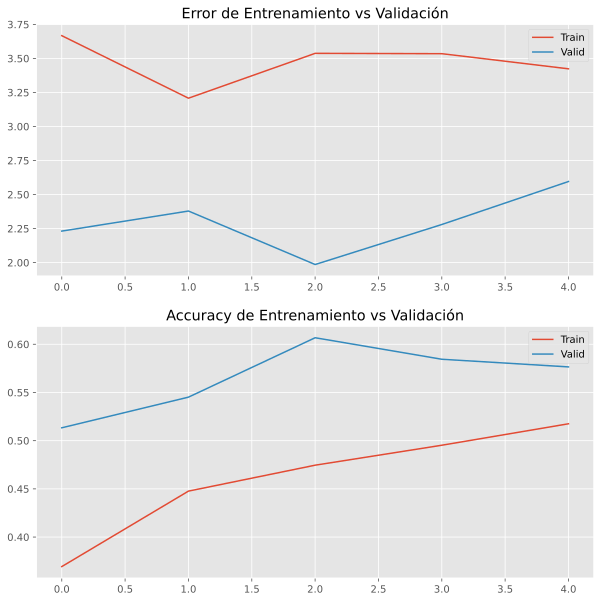

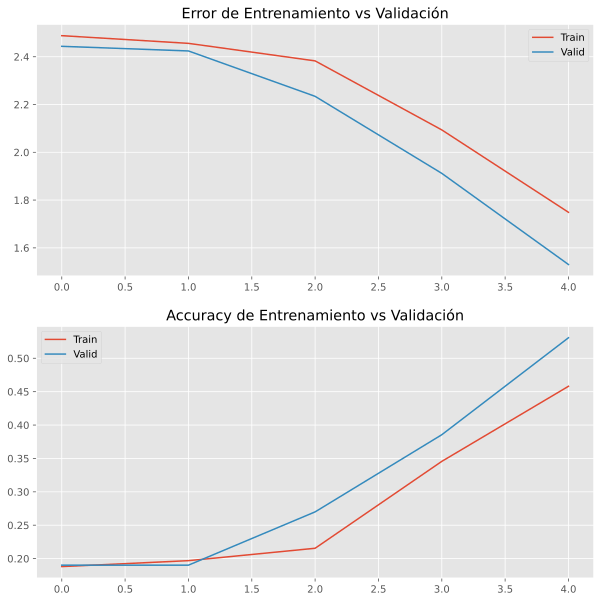

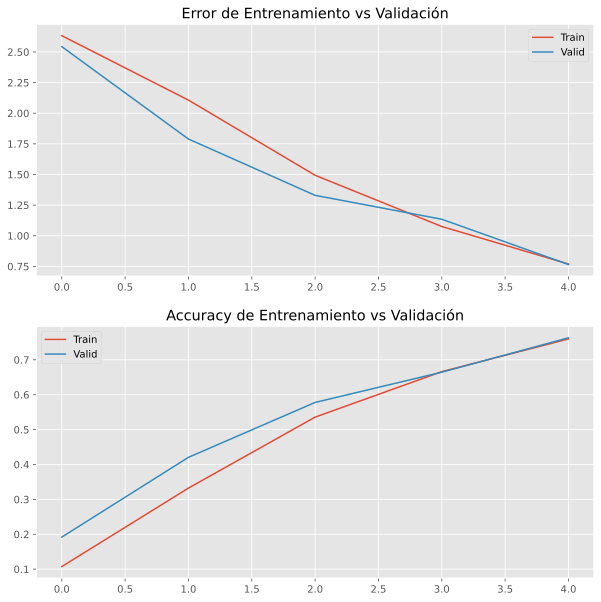

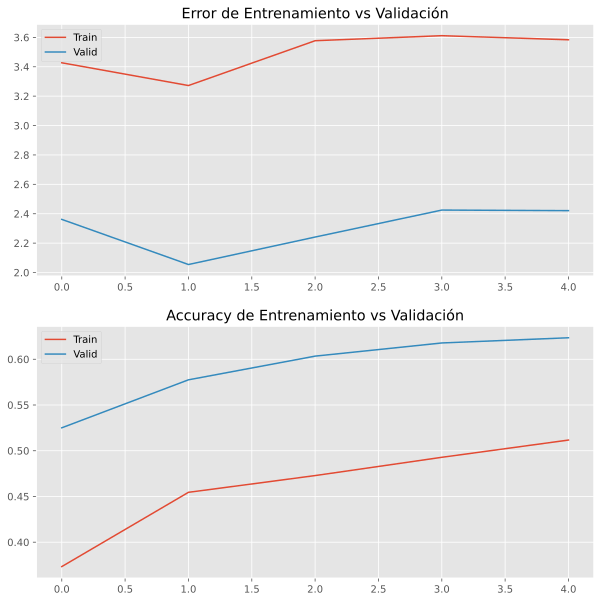

In [29]:
print("VGG9 con train set estandar")
optimizer = torch.optim.Adam(vgg19_model.parameters(), lr=0.01)
epochs = 5
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning_vgg/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_vgg/valid")}

history = train(vgg19_model.to("cpu"), 
                optimizer, 
                loss, 
                metric,
                data,
                epochs,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

print("Custom model con train set estandar")
torchvision_model = ConvModel(CANTIDAD_CLASES)
torchvision_optimizer = torch.optim.Adam(torchvision_model.parameters(), lr=0.0001)
torchvision_criterion = torch.nn.CrossEntropyLoss()
torchvision_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
torchvision_data = {"train": train_loader, "valid": valid_loader,
                    "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

torchvision_writer = {"train": SummaryWriter(log_dir="data_aug/torchvision_train"),
                      "valid": SummaryWriter(log_dir="data_aug/torchvision_valid")}

history = train(torchvision_model, 
                torchvision_optimizer, 
                torchvision_criterion, 
                torchvision_metric,
                torchvision_data,
                epochs,
                torchvision_writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

print("Custom model con train set balanceado con augmentation")
torchvision_model_for_balanced = ConvModel(CANTIDAD_CLASES)
torchvision_optimizer = torch.optim.Adam(torchvision_model_for_balanced.parameters(), lr=0.0001)
torchvision_criterion = torch.nn.CrossEntropyLoss()
torchvision_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
torchvision_data = {"train": train_balanced_loader, "valid": valid_balanced_loader,
                    "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

torchvision_writer = {"train": SummaryWriter(log_dir="data_aug/torchvision_train"),
                      "valid": SummaryWriter(log_dir="data_aug/torchvision_valid")}

history = train(torchvision_model_for_balanced, 
                torchvision_optimizer, 
                torchvision_criterion, 
                torchvision_metric,
                torchvision_data,
                epochs,
                torchvision_writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])


print("VGG19_BN_Weights con train set balanceado con augmentation")
weights = VGG19_BN_Weights.IMAGENET1K_V1
transforms = weights.transforms()

vgg19_model_balanced = torchvision.models.vgg19_bn(weights=weights)


for param in vgg19_model_balanced.parameters():
    param.requires_grad = False
last_layer_in_features = vgg19_model_balanced.classifier[-1].in_features
vgg19_model_balanced.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)
optimizer = torch.optim.Adam(vgg19_model_balanced.parameters(), lr=0.01)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning_vgg/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_vgg/valid")}

history = train(vgg19_model_balanced.to("cpu"), 
                optimizer, 
                loss, 
                metric,
                data,
                epochs,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

torch.save({
            'vgg19_model': vgg19_model.state_dict(),
            'torchvision_model': torchvision_model.state_dict(),
            'torchvision_model_for_balanced': torchvision_model_for_balanced.state_dict(),
            'vgg19_model_balanced': vgg19_model_balanced.state_dict()
            }, '/models/brain_tumor_classification.pt')

Modelo elegido: Custom model con train set balanceado con augmentation

In [41]:
epochs = 50

torchvision_optimizer = torch.optim.Adam(torchvision_model_for_balanced.parameters(), lr=0.0001)
torchvision_criterion = torch.nn.CrossEntropyLoss()
torchvision_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
torchvision_data = {"train": train_balanced_loader, "valid": valid_balanced_loader,
                    "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

torchvision_writer = {"train": SummaryWriter(log_dir="data_aug/torchvision_train"),
                      "valid": SummaryWriter(log_dir="data_aug/torchvision_valid")}

history = train(torchvision_model_for_balanced, 
                torchvision_optimizer, 
                torchvision_criterion, 
                torchvision_metric,
                torchvision_data,
                epochs,
                torchvision_writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



Epoch: 1/50 - Train loss 0.504774 - Train Accuracy 0.843672 - Valid Loss 0.562236 - Valid Accuracy 0.825687
Epoch: 2/50 - Train loss 0.355606 - Train Accuracy 0.891659 - Valid Loss 0.474542 - Valid Accuracy 0.856895
Epoch: 3/50 - Train loss 0.264079 - Train Accuracy 0.919515 - Valid Loss 0.365960 - Valid Accuracy 0.888145
Epoch: 4/50 - Train loss 0.192364 - Train Accuracy 0.941713 - Valid Loss 0.424276 - Valid Accuracy 0.869233
Epoch: 5/50 - Train loss 0.146787 - Train Accuracy 0.955758 - Valid Loss 0.313976 - Valid Accuracy 0.907946
Epoch: 6/50 - Train loss 0.101387 - Train Accuracy 0.968867 - Valid Loss 0.296197 - Valid Accuracy 0.920497
Epoch: 7/50 - Train loss 0.106132 - Train Accuracy 0.967463 - Valid Loss 0.327983 - Valid Accuracy 0.912780
Epoch: 8/50 - Train loss 0.070762 - Train Accuracy 0.977528 - Valid Loss 0.316289 - Valid Accuracy 0.920285
Epoch: 9/50 - Train loss 0.067080 - Train Accuracy 0.979401 - Valid Loss 0.271892 - Valid Accuracy 0.928214
Epoch: 10/50 - Train loss 0.

KeyboardInterrupt: 

In [43]:
train_loss = [2.632774,2.106972,1.493447,1.075376,0.769226,0.504774,0.355606,0.264079,0.192364,0.146787,0.101387,0.106132,0.070762,0.067080,0.084575,0.021944,0.029123,0.083811,0.024144,0.018182,0.051229,0.046300,0.018411,0.066319,0.027242,0.025521,0.003130,0.000339,0.000186,0.000137,0.000105,0.000084,0.000068,0.000056,0.000046,0.000039,0.000033,0.000028]
train_acc = [0.107366,0.332358,0.535776,0.666159,0.759909,0.843672,0.891659,0.919515,0.941713,0.955758,0.968867,0.967463,0.977528,0.979401,0.975890,0.994967,0.990715,0.976124,0.993875,0.995318,0.984590,0.986423,0.994967,0.983146,0.991807,0.992509,0.999298,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000]
valid_loss = [2.543345,1.789275,1.329729,1.134521,0.765216,0.562236,0.474542,0.365960,0.424276,0.313976,0.296197,0.327983,0.316289,0.271892,0.225415,0.203572,0.535845,0.343048,0.273604,0.191273,0.338480,0.237867,0.245989,0.228132,0.283918,0.200433,0.170210,0.173220,0.174710,0.174980,0.177738,0.180387,0.180730,0.183474,0.184337,0.186315,0.187061,0.189603]
valid_acc = [0.191825,0.420539,0.577849,0.664561,0.763229,0.825687,0.856895,0.888145,0.869233,0.907946,0.920497,0.912780,0.920285,0.928214,0.946150,0.947549,0.891579,0.926348,0.935210,0.952892,0.908836,0.944751,0.941952,0.941231,0.937500,0.951959,0.960821,0.959422,0.960354,0.960821,0.961754,0.961287,0.960821,0.960821,0.961287,0.961754,0.962687,0.962687]

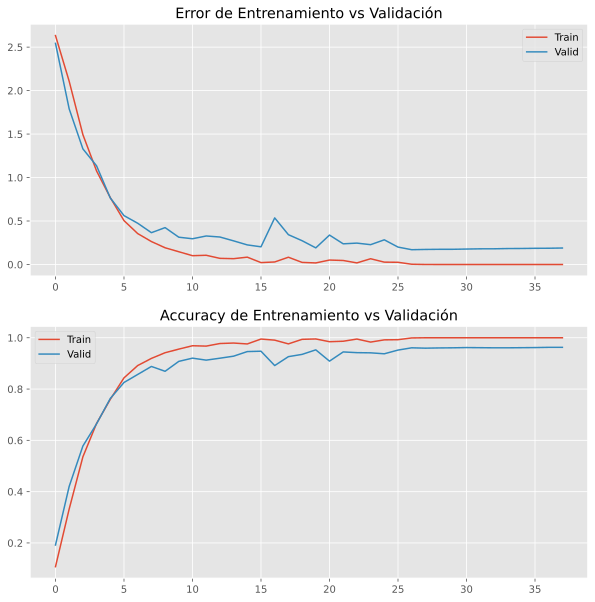

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_loss) 
axs[0].plot(valid_loss) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [61]:
torch.save(vgg19_model.state_dict(), 'models/brain_tumor_classification.pt')

Podemos testear el modelo con algunos ejemplos

In [77]:
def test_model(actual_model, max_tests = 5):
    tests = 0
    for data,label in valid_loader:
            pred_labels = torch.argmax(actual_model(data),axis=1)
            
            for d, l, pred in zip(data, label, pred_labels):
                tests += 1
                plt.figure()
                img = d
                plt.imshow(F.to_pil_image(img))
                true = brain_data.encoder.classes_[l]
                pred = brain_data.encoder.classes_[pred]
                plt.axis("off")
                plt.grid()
                plt.title(f"Verdadero: {true} | Inferido: {pred}")
                if tests == max_tests:
                     return


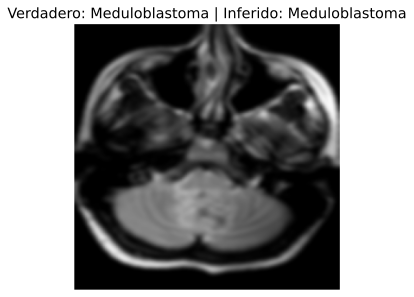

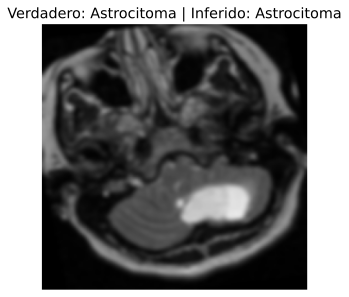

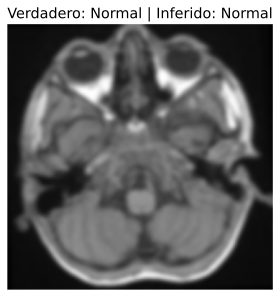

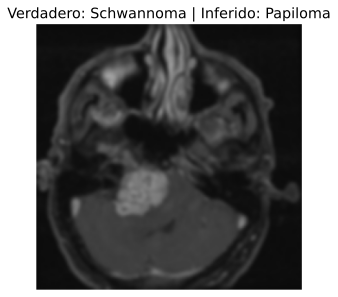

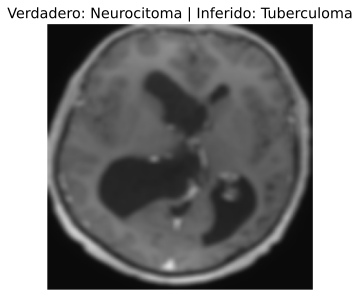

In [81]:
test_model(torchvision_model_for_balanced)

In [79]:
def check_model_errors(actual_model, errors = 5):
    tests = 0
    for data,label in valid_loader:
            pred_labels = torch.argmax(actual_model(data),axis=1)
            
            idxs = torch.nonzero(pred_labels != label).T[0]
            
            for i in idxs:
                tests += 1
                plt.figure()
                img = data[i]
                plt.imshow(F.to_pil_image(img))
                true = brain_data.encoder.classes_[label[i]]
                pred = brain_data.encoder.classes_[pred_labels[i]]
                plt.axis("off")
                plt.grid()
                plt.title(f"Verdadero: {true} Inferido: {pred}")
                if tests == errors:
                     return

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



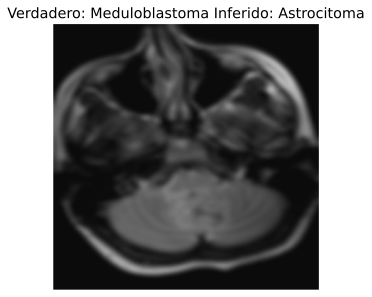

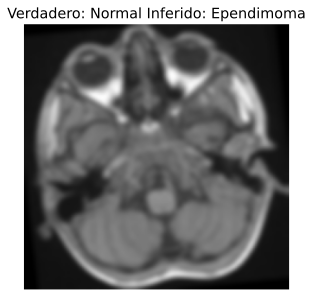

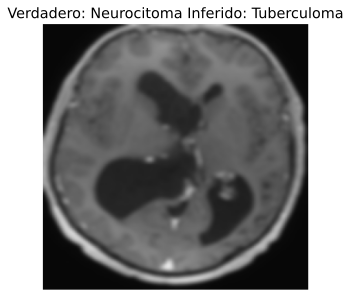

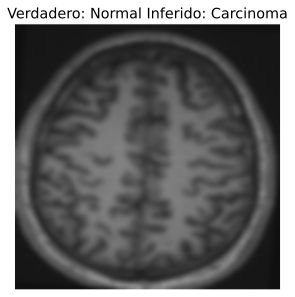

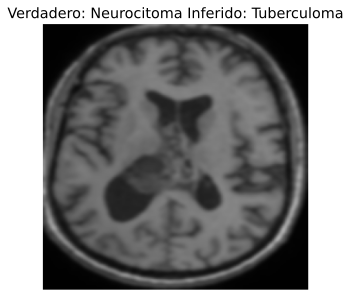

In [87]:
check_model_errors(torchvision_model_for_balanced)

In [86]:
from torchinfo import summary

summary(torchvision_model_for_balanced)

Layer (type:depth-idx)                   Param #
ConvModel                                --
├─Conv2d: 1-1                            448
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            4,640
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            18,496
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            73,856
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            295,168
├─MaxPool2d: 1-10                        --
├─Conv2d: 1-11                           1,180,160
├─MaxPool2d: 1-12                        --
├─Linear: 1-13                           2,359,808
├─Linear: 1-14                           7,695
Total params: 3,940,271
Trainable params: 3,940,271
Non-trainable params: 0

In [88]:
def predictions_data(actual_model):
    labels = []
    predictions = []
    for data,label in valid_loader:
            pred_labels = torch.argmax(actual_model(data),axis=1)
            
            labels.append(label)
            predictions.append(pred_labels)

    return labels, predictions

In [90]:
true, pred = predictions_data(torchvision_model_for_balanced)

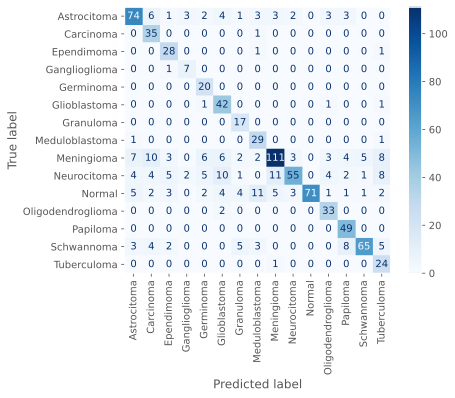

In [91]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(torch.cat(true),torch.cat(pred),display_labels=brain_data.encoder.classes_,xticks_rotation='vertical',cmap='Blues')
plt.grid(visible=False)